In [1]:
import numpy as np
import basic
import cosmology
import misctools
import local
from matplotlib.pyplot import *

Using CAMB 1.3.2 installed at /global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/camb


In [2]:
import importlib
importlib.reload(local)

Using CAMB 1.3.2 installed at /global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/camb


<module 'local' from '/global/u1/t/toshiyan/Work/Ongoing/bispec/z-clean/local.py'>

In [3]:
lmin, lmax = 1, 2048
L = np.linspace(0,lmax,lmax+1)
kk_noise = 's4'
lss_zbin = 6

In [4]:
k, pk0 = np.loadtxt(local.root + 'modelw/Pk/Pklin_new.dat',unpack=True)

In [5]:
# source redshift
zs = [local.zcmb,local.zcmb,local.zcmb]

In [6]:
zn = 100

In [7]:
zmin, zmax = 0.0001, 20
z, dz = basic.bispec.zpoints(zmin,zmax,zn)
chi = basic.cosmofuncs.dist_comoving(z,**local.cps)
Hzi = basic.cosmofuncs.hubble(z,divc=True,**local.cps)
rzi = basic.cosmofuncs.dist_comoving(z,**local.cps)

In [8]:
# gal coefficient
frac = local.galaxy_distribution(np.linspace(0,50,1000),zbn={'lss':lss_zbin})[3]
Scov = local.get_covariance_signal(lmax,add_lss=lss_zbin)
slss = local.get_covariance_signal(lmax,add_cmb=False,add_cib=False,add_lss=lss_zbin)
nlss = local.get_covariance_noise(lmax,frac=frac,add_cmb=False,add_cib=False,add_lss=lss_zbin)
vecs = Scov[0,2:2+lss_zbin,:]
ocov = slss + nlss
icov = ocov.copy()
icov[:,:,1:] = np.array( [ np.linalg.inv(ocov[:,:,l]) for l in range(1,lmax+1) ] ).T
coef = np.array( [ np.dot( icov[:,:,l], vecs[:,l] ) for l in range(lmax+1) ] )

In [9]:
# gal weight
zbin, dndzi, pz, __ = local.galaxy_distribution(z,zbn={'lss':lss_zbin})
wgal = np.zeros((lss_zbin,zn))
for zi in range(lss_zbin):
    wgal[zi,:] = Hzi*dndzi['lss']*pz['lss'][zi]*(1+.84*z)/frac['lss'][zi]

In [10]:
frac['lss']

{0: 0.10033342858109964,
 1: 0.07228847567034886,
 2: 0.05001255547115544,
 3: 0.045728404943414964,
 4: 0.03284471135059052,
 5: 0.014289194531353508}

In [12]:
# modified kernel
wdel = np.zeros((zn,lmax+1))
for l in range(lmax+1):
    wdel[:,l] = 0.
    for zi in range(lss_zbin):
        wdel[:,l] += coef[l,zi]*wgal[zi,:]
    #wdel[:,l] = coef[l,0]*wgal[0,:]

In [13]:
clgg = np.zeros((6,lmax+1))
clgg[:,8:2008] = np.loadtxt("/global/homes/t/toshiyan/Work/Ongoing/sobs/data/sodelens/aux/byeonghee/LSST_gold_6tomobins/clgg_LSSTgold_6tomobins.dat")

In [14]:
zid = 3

In [15]:
# clkk
skk = basic.bispec.cl_flat(local.cpmodel,z,dz,zs[:2],lmax,k,pk0)
dkk = basic.bispec.cl_flat(local.cpmodel,z,dz,zs[:2],lmax,k,pk0,wdel=wdel)
sgg = basic.bispec.cl_flat(local.cpmodel,z,dz,zs[:2],lmax,k,pk0,dNdz=dndzi['lss']*pz['lss'][zid]/frac['lss'][zid]*(1+.84*z),cltype='gg')

In [16]:
print(frac['lss'][zid],norm[zid])

0.045728404943414964 0.04572876660055017


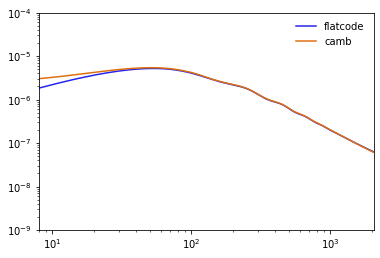

In [17]:
xlim(8,lmax)
ylim(1e-9,1e-4)
xscale('log')
yscale('log')
#plot(skk)
#plot(dkk)
plot(sgg,label='flatcode')
#plot(clgg[zid],label='ref')
plot(slss[zid,zid,:],label='camb')
legend()

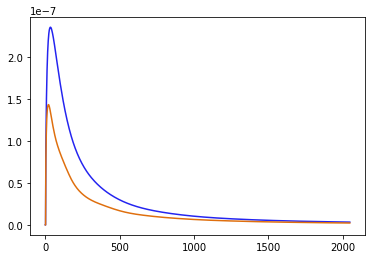

In [18]:
plot(skk)
plot(dkk)

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


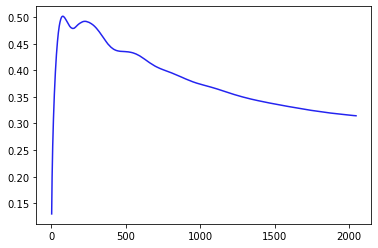

In [19]:
plot(1-dkk/skk)